In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline
from IPython.display import display



# Coordinates transformation

In [5]:
#Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

# Open/Read file



Read data:
- Input: 1 row of data_file.txt, e.g. 1 event, passed as a list
- Output: pandas dataframe as in the Data Format paragraph, Number of the Event, Number of hits in the Event

This function takes in input one event at time, and then outputs a pandas dataframe as described in the previous section. In addition, the transformation from local to global coordinates is performed.

In [ ]:
def read_data(event):    
    event_number = int(event[0])
    hits_number  = int(event[1])
    if hits_number == 0:
        hit       = [np.nan]
        chamber   = [np.nan]
        layer     = [np.nan]
        xl_local  = [np.nan]
        xr_local  = [np.nan]
        z_local   = [np.nan]
        time      = [np.nan]
        xl_global = [np.nan]
        xr_global = [np.nan]
        z_global  = [np.nan]
    else:
        hit       = np.arange(hits_number)
        chamber   = np.fromiter((event[2+5*i] for i in range(hits_number)), int)
        layer     = np.fromiter((event[3+5*i] for i in range(hits_number)), int)
        xl_local  = np.fromiter((event[4+5*i] for i in range(hits_number)), float)
        xr_local  = np.fromiter((event[5+5*i] for i in range(hits_number)), float)
        z_local   = np.fromiter((local_z_shifts[i-1]+ZCELL/2 for i in layer), float)
        time      = np.fromiter((event[6+5*i] for i in range(hits_number)), float)
        xl_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xl_local
        xr_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xr_local
        z_global  = np.fromiter((global_z_shifts[i] for i in chamber), float) + z_local
        
    dataframe = pd.DataFrame(
        { 'EvNumber' : event_number,
          'Hit'      : hit,
          'Chamber'  : chamber,
          'Layer'    : layer,
          'XL_local' : xl_local,
          'XR_local' : xr_local,
          'Z_local'  : z_local,
          'Time'     : time,
          'XL_global': xl_global,
          'XR_global': xr_global,
          'Z_global' : z_global,
        })

        
    #dataframe.set_index('Hit', inplace=True) # set as index the number of the hit 
    return dataframe, event_number, hits_number


"""come aprire un pacco di eventi e farli processare:

data_file ="/Users/federicob/Documents/data/calibration/Run000262/data_000000.txt"
with open(data_file) as f:
    for line in f:
        event = line.split()
        event = [float(i) for i in event]
        #print(event)
        ev, evNumber, hits = read_data(event)
        ......................................
        .....richiami alle altri funzioni.....
        ......................................
        """





# Task 1/2: display the events
### both local and global display


Plot background
- Input: None
- Output: list[pyplot Axes] (global image + 4 detectors zooms)
The input of the function is the pandas dataframe made by the Read Data function. Five plots are given as output: one image of the whole detector, and one for each of the 4 chambers. In the images there will be the points of the hits tracked in the event (left/right positions must have different colors).
Instead of having 4 different 2D numpy arrays with the coordinates of the vertices of the 4 chambers, we create a pandas DataFrame with the following columns:

| chamber | x_vertices | y_vertices |

where x_vertices, y_vertices contain a list with the four x/y coordinates of the 4 vertices of the chamber.

In [20]:
def plot_background():
    # create Pandas DataFrame for the cambers positions
    chamber_position = pd.DataFrame({
    'chamber' : [i for i in range(4)],
    'x_vertices' : [(global_x_shifts[i], global_x_shifts[i] - 720, global_x_shifts[i] - 720, global_x_shifts[i])
                    for i in range(4)],
    'y_vertices' : [(global_z_shifts[i], global_z_shifts[i], global_z_shifts[i] + 52, global_z_shifts[i] + 52)
                    for i in range(4)],
    })
    x_lim = [[-1000, 1000], # global detector
             [    0, 1000], # chamber 0
             [    0, 1000], # chamber 1
             [-1000,    0], # chamber 2
             [-1000,    0]] # chamber 3
    y_lim = [[-100, 1000],  # global detector
             [800 ,  900],  # chamber 0
             [ -25,   75],  # chamber 1
             [ 800,  900],  # chamber 2
             [ -25,   75]]  # chamber 3
    title = ["DETECTOR", "Chamber 0", "Chamber 1", "Chamber 2", "Chamber 3"]
    # create pyplot 'Axes' objects
    ax_global = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
    ax_0 = plt.subplot2grid(gridsize, (2, 1), colspan=1, rowspan=1) # top-right
    ax_1 = plt.subplot2grid(gridsize, (3, 1), colspan=1, rowspan=1) # bottom-right
    ax_2 = plt.subplot2grid(gridsize, (2, 0), colspan=1, rowspan=1) # top-left
    ax_3 = plt.subplot2grid(gridsize, (3, 0), colspan=1, rowspan=1) # bottom-left
    
    axes = [ax_global, ax_0, ax_1, ax_2, ax_3]
    for index, ax in enumerate(axes):
        ax.set_xlim(x_lim[index])
        ax.set_ylim(y_lim[index])
        ax.set_xlabel("x [mm]")
        ax.set_ylabel("z [mm]")
        if index == 0: ax.set_title(title[index])
        else: ax.set_title(title[index], pad=-20)
        # plot the 4 chambers in each 'Axes'
        for j in range(4):
            chamber = chamber_position[chamber_position["chamber"] == j]
            ax.fill(chamber["x_vertices"].values[0], chamber["y_vertices"].values[0], color='gray', fill=False)
    return axes

Plot events:

- Input: Pandas DataFrame (1 event) + event number
- Output: list[pyplot Axes] (global image + 4 detectors zooms)

The input of the function is the Pandas DataFrame made by the Read Data function, and the event number (this is due to the fact that, if the are no hits, the DataFrame is empty, and therefore we can't get the Event number from that). Five plots are given as output: one image of the whole detector, and one for each of the 4 chambers. In the images there will be the points of the hits tracked in the event (left/right positions must have different colors).

In [18]:
def plot_events(dataframe, evNumber):
    # get the EvNumber as argument, because, if the dataframe is empty,
    # I can't get it from data
    plots = plot_background()
    plots[0].set_title("Event:"+str(evNumber), {'size':'18'})
    if dataframe.empty == False:
        xL = dataframe["XL_global"]
        xR = dataframe["XR_global"]
        z  = dataframe["Z_global"]
        for index, image in enumerate(plots):     
            image.plot(xL, z, "bo", markersize=3)
            image.plot(xR, z, "ro", markersize=3)
    return plots


"""come chiamare le ultime due funzioni:

gridsize = (5, 2)
fig = plt.figure(figsize = (12, 24))
axes = plot_background()
axes = plot_events(ev, evNumber)
plt.show()
"""


'come chiamare le ultime due funzioni:\n\ngridsize = (5, 2)\nfig = plt.figure(figsize = (12, 24))\naxes = plot_background()\naxes = plot_events(ev, evNumber)\nplt.show()\n'

# Task 3: event selection



- Input: Pandas DataFrame
- Output: True/False, list with involved chambers numbers, list with number of different layers per chamber

The input of the function is the Pandas DataFrame made by the Read Data function. The output is a boolean value, which labels the good calibration events, a list with the number of the chambers involved (0,1) or (2,3), and a list with the number of hit layers for each chamber.
Good events requires at least 3 hits in different layers for each chamber, either in the left or in the right side of the detector.

In [15]:
def select_events(dataframe,hits_number):
        
        
        
        if (hits_number < 6 or hits_number > 20):
            select=False
            chambers=[]
            n_layer=[]
            return select, chambers, n_layer 

        else:
            #hits only in the right side
            if((dataframe['Chamber']<=1).all()):
                chambers=[0,1]
                #compute number of different layers in each chamber
                n_layer_ch0 = dataframe[dataframe['Chamber']==0]['Layer'].nunique()
                n_layer_ch1 = dataframe[dataframe['Chamber']==1]['Layer'].nunique()
                
                n_layer=[n_layer_ch0, n_layer_ch1]
                
                #require at least 3 different layers for each chamber
                if(n_layer_ch0>=3 and n_layer_ch1>=3):
                    select=True
                    return select, chambers, n_layer
                else:
                    select=False
                    return select, chambers, n_layer
                
            #hits only in the left side
            elif((dataframe['Chamber']>=2).all()):
                chambers=[2,3]
                #compute number of different layers in each chamber
                n_layer_ch2 = dataframe[dataframe['Chamber']==2]['Layer'].nunique()
                n_layer_ch3 = dataframe[dataframe['Chamber']==3]['Layer'].nunique() 
                
                n_layer=[n_layer_ch2, n_layer_ch3]
                
                #require at least 3 different layers for each chamber
                if(n_layer_ch2>=3 and n_layer_ch3>=3):
                    select=True
                    return select, chambers, n_layer
                else:
                    select=False
                    return select, chambers, n_layer
            
            #hits in both left and right side
            else:
                select=False
                chambers=[]
                n_layer=[]
                return select, chambers, n_layer 
        
        
        
"""come chiamare la funzione:
print(select_events(ev,hits))            
print(ev)
condition, chambers, n_layers= select_events(ev)
print(condition)
"""

'come chiamare la funzione:\nprint(select_events(ev,hits))            \nprint(ev)\ncondition, chambers, n_layers= select_events(ev)\nprint(condition)\n'

# Task 4: local linear fit

- Input: Pandas DataFrame, list with involved chambers numbers, list with number of different layers per chamber
- Output: list of 2 dictionaries, one for each chamber, containing fit results

The input of the function are the Pandas DataFrame made by the read_data function, and the two list returned by the select_events function. The output is a list of 2 dictionaries, one for each chamber, containing slope, intercept, numpy array with best combination of points and number of the excluded layer.
The best combination of points is the one with the least Chi Squared.

In [ ]:
import random
from scipy import stats

def local_fit(dataframe, list_chambers, list_layers):
    #list to store results for each chamber
    results=[]
    #loop over the (two) chambers
    for i in range(0,len(list_chambers)):
       #if we have 4 different layers we randomly select a layer to be excluded
       #we will use the point from the excluded layer to check the goodness of the global fit
        if(list_layers[i]==4):
            rand_layer=random.randint(1,4)
        else:
            rand_layer=0 #layers are 1,2,3,4: excluding layer 0 is equivalent to keeping them all
        
        #create dataframe_cl filtered by chamber and excluded layer
        dataframe_c = dataframe[dataframe['Chamber']==list_chambers[i]] #dataframe filtered by chamber
        dataframe_cl = dataframe_c[dataframe_c['Layer']!=rand_layer]    #filtered by chamber and excluded layer
        
        # Z local coordinates corresponding to the 4 different layers
        Z=[6.5,19.5, 32.5, 45.5]
        
        #create a list l containing 3 lists of points (z,x), one for each selected layer
        l=[]
        
        #loop over selected layers and fill l
        for layer_index in dataframe_cl['Layer'].unique():
            XR=np.array(dataframe_cl[dataframe_cl['Layer']==layer_index]['XR_local'])
            XL=np.array(dataframe_cl[dataframe_cl['Layer']==layer_index]['XL_local'])
            
            z=Z[(layer_index-1)] #layer_index is in range [1,4], list index must be in range [0,3]
            l_temp=[]
            
            for x in XR:
                l_temp.append((z,x))
            for x in XL:
                l_temp.append((z,x)) 
            l.append(l_temp) 
            
        #create numpy array with all possible combinations of 3 points p1,p2,p3
        combinations=np.array([(p1,p2,p3) for p1 in l[0] for p2 in l[1] for p3 in l[2]])
        
        #interpolate each combination and select the combination with least chi squared
        min_chisq=100000 #to store minimum chisq
        optimal_comb=np.zeros((3,2)) #to store best combination of points
        slope_opt=0 #to store slope obtained with the best combination
        intercept_opt=0 #to store intercept obtained with the best combination
        for points in combinations:
            #linear regression
            slope, intercept, r_value, p_value, std_err=stats.linregress(points[:,0],points[:,1])
            #compute expected x using the interpolating function
            expect_x=intercept+slope*(points[:,0])
            #compute chi squared
            chisq, p_value=stats.chisquare(points[:,1],expect_x)
            #eventually update min_chisq and optimal_comb
            if(chisq<min_chisq):
                min_chisq=chisq
                optimal_comb=points
                slope_opt=slope
                intercept_opt=intercept
            else:
                continue
                  
        
        #add to results: results is a list of 2 dictionaries, one for each chamber       
        results.append({"slope":slope_opt, 
                        "intercept":intercept_opt, 
                        "optimal_comb": optimal_comb, 
                        "excl_layer": rand_layer})
                   
    return results



"""come chiamare la funzione:
lf_results=local_fit(ev, chambers, n_layers)
print("Prima camera\n",lf_results[0])
print("Seconda camera\n", lf_results[1])
"""

# Task 5: global linear fit

- Input: Pandas DataFrame, list with involved chambers numbers, output list of local_fit function
- Output: Dictionary containing fit results

The input of the function are the Pandas DataFrame made by the read_data function, the list with involved chambers numbers returned by the select_events function and the list of 2 dictionaries returned by the local_fit function. The output is a dictionary containing slope, intercept and a numpy array with residuals computed for the eventual test layers. Praticamente prende i tre migliori di ognuna delle due camere e fa il fit globale con questi 3.




#### La valeria aveva scritto questo anche se non capisco molto perchè non vada bene visto che i fit escono.
Nota provvisoria: in questo caso non credo si possa calcolare il chi quadro poiché le x possono essere negative. Per il test del chi quadro il valore atteso deve essere positivo (di solito sono frequenze), altrimenti viene un chi quadro negativo (??)



In [ ]:
from math import fabs

def global_fit(dataframe, list_chambers, lfit_results):
    
    #TRANSFORM LOCAL COORDINATES IN GLOBAL COORDINATES
    
    #First chamber:
    global_z_ch1 = global_z_shifts[list_chambers[0]]+lfit_results[0]["optimal_comb"][:,0]
    global_x_ch1 = global_x_shifts[list_chambers[0]]-lfit_results[0]["optimal_comb"][:,1]
    global_ch1=np.column_stack((global_z_ch1, global_x_ch1))
    
    #Second chamber:
    global_z_ch2 = global_z_shifts[list_chambers[1]]+lfit_results[1]["optimal_comb"][:,0]
    global_x_ch2 = global_x_shifts[list_chambers[1]]-lfit_results[1]["optimal_comb"][:,1]
    global_ch2=np.column_stack((global_z_ch2, global_x_ch2))
    
    points=np.concatenate((global_ch1, global_ch2))
    #print(points)
    #LINEAR REGRESSION
    slope, intercept, r_value, p_value, std_err=stats.linregress(points[:,0],points[:,1])
    
    #compute expected x using the interpolating function
    expect_x=intercept+slope*(points[:,0])
        
    #COMPUTE RESIDUALS USING TEST LAYER (layer excluded in local fit function)
    # Z local coordinates corresponding to the 4 different layers
    Z_local=[6.5,19.5, 32.5, 45.5]
    #list to store residuals
    res=[]
    #compute residuals for each chamber
    for c in range(0,len(list_chambers)):
        dataframe_c = dataframe[dataframe['Chamber']==list_chambers[c]] #dataframe filtered by chamber
        res_temp=[]
        excl_layer=lfit_results[c]["excl_layer"]
        #test layer Z global coordinate 
        Z_test_layer=global_z_shifts[c]+Z_local[(excl_layer-1)]
        #if there were only 3 layers, excl_layer was set to 0:
        if(excl_layer!=0): 
            expect_x=intercept+slope*(Z_test_layer)
            XR=np.array(dataframe_c[dataframe_c['Layer']==excl_layer]['XR_global'])
            XL=np.array(dataframe_c[dataframe_c['Layer']==excl_layer]['XL_global'])
            for i in range(0,XR.size):
                res_temp.append(XR[i]-expect_x)
            for i in range(0,XL.size):
                res_temp.append(XL[i]-expect_x)
                
            res_temp.sort(key=fabs) #we want the smallest residual in absolute value
            res.append(res_temp[0])
        else:
            res=[]
    #convert list res in numpy array  
    res=np.array(res) 
    #plt.plot(points[:,0],points[:,1], 'o')
    #plt.plot(points[:,0],intercept+slope*points[:,0], 'r')
    #plt.show()
    return {"slope": slope, "intercept": intercept, "residuals": res }
    
"""come chiamare la funzione:
gf_results=global_fit(ev, chambers, lf_results)
print(gf_results)
"""

# Task 6: efficency

# Task 7: display the fit

#### la Valeria qui aveva scritto:
QUESTA FUNZIONE VA RIFATTA, E' UNA BOZZA CHE SERVIVA A ME PER VEDERE COME ERANO I FIT se deve funzionare come event display deve chiamare le funzioni select_events e local_fit e global_fit al suo interno e non prederne i risultati come argomento.

#### io dico: 
se gliela mettiamo di seguiti alle funzioni di selezione e di local/global fit secondo me si può lasciare così


In [ ]:
def plot_fit(dataframe, evNumber, chambers, lf_results, gf_results):
    # get the EvNumber as argument, because, if the dataframe is empty,
    # I can't get it from data
    plots = plot_background()
    plots= plot_events(dataframe, evNumber)
    plots[0].set_title("Event:"+str(evNumber), {'size':'18'})    
    
    z_glob=[x for x in range(0,1001)]
    z_glob=np.array(z_glob)
    
    #print(chambers)
    #LOCAL FIT
    for i in range(0,len(chambers)):
        #slope
        slope_loc=-lf_results[i]['slope'] #in global coordinates the local slope takes a minus sign
        #print(slope_loc)
        #intercept in global coordinates
        intercept_loc=global_x_shifts[chambers[i]]-lf_results[i]['intercept']-slope_loc*global_z_shifts[chambers[i]]
        #print(intercept_loc)
        for index, image in enumerate(plots):
            image.plot(slope_loc*z_glob+intercept_loc,z_glob, '--', 'b')
        
                 
    #GLOBAL FIT
    slope=gf_results['slope']
    intercept=gf_results['intercept']
    for index, image in enumerate(plots):
        image.plot(slope*z_glob+intercept, z_glob, 'b')
        
    plt.show()
    
    return plots

"""per chiamare la funzione:
axes= plot_fit(ev, evNumber,chambers, lf_results, gf_results)
"""

# Prova di run

In [ ]:
data_file ="/Users/federicob/Documents/Physics_of_data/final_p/data/data_merged/calibration/sinistra.txt"
count=0
tot=0
eventi_selezionati=0
eventi_totali=0
residuals=[]
x_punti_sopra=[]
x_punti_sotto=[]
#stampo un plot ogni 10
A=0
with open(data_file) as f:
    for line in f:
        event = line.split()
        event = [float(i) for i in event]
        eventi_totali += 1
        
        
        #Open and read the event
        ev, evNumber, hits = read_data(event)
        
        #print(ev)
        #Select the event
        condition, chambers, n_layers= select_events(ev,hits)
        tot+=1
        
        if(condition==True):
            eventi_selezionati +=1

            
            #Local linear fit
            lf_results=local_fit(ev, chambers, n_layers)
            #Global linear fit
            gf_results=global_fit(ev, chambers, lf_results)
            residuals.append(gf_results["residuals"])
            count+=1
            
            
            #Creo i due array contenenti i 
            
            for j in lf_results[0]["optimal_comb"]:
                x_punti_sopra.append(j[1])
                
                
                
            for j in lf_results[1]["optimal_comb"]:
                x_punti_sotto.append(j[1])
                
                
            
            
            

            
            #questo serve a plottare
            """if (A//30)==0:
                #Plot selected event
                gridsize = (5, 2)
                fig = plt.figure(figsize = (12, 24))
                axes = plot_background()
                axes = plot_events(ev, evNumber)
                axes= plot_fit(ev, evNumber,chambers, lf_results, gf_results)
                plt.show()
            A += 1"""

            



In [ ]:
print("Hist for the left chambers")
            
plt.figure(figsize=(8, 6))
plt.title("Upper chamber")
plt.hist(x_punti_sopra,bins=17,edgecolor='black', linewidth=1.2)
plt.show()
            
plt.figure(figsize=(8, 6))
plt.title("Lower chamber")
plt.hist(x_punti_sotto,bins=17,edgecolor='black', linewidth=1.2)
plt.show()

In [ ]:
Hit_0=0
Hit_1=0
Hit_2=0
Tot_res=[]
for i in range(0,len(residuals)):
    if len(residuals[i])==0:
        Hit_0 +=1
    elif len(residuals[i])==1:
        Hit_1 +=1
        Tot_res.append(np.abs(residuals[i][0]))

    elif len(residuals[i])==2:
        Hit_2 +=1
        Tot_res.append(np.abs(residuals[i][0]))
        Tot_res.append(np.abs(residuals[i][1]))


print("percentuale  con 2 esclusi: ",Hit_0/len(residuals)*100," %")
print("percentuale  con 1 esclusi: ",Hit_1/len(residuals)*100," %")
print("percentuale  con 0 esclusi: ",Hit_2/len(residuals)*100," %")


plt.figure(figsize=(8, 6))
plt.title("Residuals of the points in the excluded layers")
plt.hist(Tot_res,bins=np.linspace(0,20,50),edgecolor='black', linewidth=1.2)
plt.show()

In [ ]:
 data_file ="/Users/federicob/Documents/Physics_of_data/final_p/data/calibration/Run000263/r263.txt"
count=0
tot=0
eventi_selezionati=0
eventi_totali=0
residuals=[]
x_punti_sopra=[]
x_punti_sotto=[]
#stampo un plot ogni 10
A=0
with open(data_file) as f:
    for line in f:
        event = line.split()
        event = [float(i) for i in event]
        eventi_totali += 1
        
        
        #Open and read the event
        ev, evNumber, hits = read_data(event)
        
        #print(ev)
        #Select the event
        condition, chambers, n_layers= select_events(ev,hits)
        tot+=1
        
        if(condition==True):
            eventi_selezionati +=1

            
            #Local linear fit
            lf_results=local_fit(ev, chambers, n_layers)
            #Global linear fit
            gf_results=global_fit(ev, chambers, lf_results)
            residuals.append(gf_results["residuals"])
            count+=1
            
            #Creo i due array contenenti i 
            
            for j in lf_results[0]["optimal_comb"]:
                x_punti_sopra.append(j[1])
                
                
                
            for j in lf_results[1]["optimal_comb"]:
                x_punti_sotto.append(j[1])
            
            
            


In [ ]:
print("Hist for the right chambers")
            
plt.figure(figsize=(8, 6))
plt.title("Upper chamber")
plt.hist(x_punti_sopra,bins=17,edgecolor='black', linewidth=1.2)
plt.show()
            
plt.figure(figsize=(8, 6))
plt.title("Lower chamber")
plt.hist(x_punti_sotto,bins=17,edgecolor='black', linewidth=1.2)
plt.show()

In [ ]:
Hit_0=0
Hit_1=0
Hit_2=0
Tot_res=[]
for i in range(0,len(residuals)):
    if len(residuals[i])==0:
        Hit_0 +=1
    elif len(residuals[i])==1:
        Hit_1 +=1
        Tot_res.append(np.abs(residuals[i][0]))

    elif len(residuals[i])==2:
        Hit_2 +=1
        Tot_res.append(np.abs(residuals[i][0]))
        Tot_res.append(np.abs(residuals[i][1]))

print("percentuale  con 2 esclusi: ",Hit_0/len(residuals)*100," %")
print("percentuale  con 1 esclusi: ",Hit_1/len(residuals)*100," %")
print("percentuale  con 0 esclusi: ",Hit_2/len(residuals)*100," %")



plt.figure(figsize=(8, 6))
plt.title("Residuals of the points in the excluded layers")
plt.hist(Tot_res,bins=np.linspace(0,20,50),edgecolor='black', linewidth=1.2)
plt.show()

In [1]:
def read_data(event):    
    event_number = int(event[0])
    hits_number  = int(event[1])
    if hits_number == 0:
        hit       = [np.nan]
        chamber   = [np.nan]
        layer     = [np.nan]
        xl_local  = [np.nan]
        xr_local  = [np.nan]
        z_local   = [np.nan]
        time      = [np.nan]
        xl_global = [np.nan]
        xr_global = [np.nan]
        z_global  = [np.nan]
    else:
        hit       = np.arange(hits_number)
        chamber   = np.fromiter((event[2+5*i] for i in range(hits_number)), int)
        layer     = np.fromiter((event[3+5*i] for i in range(hits_number)), int)
        xl_local  = np.fromiter((event[4+5*i] for i in range(hits_number)), float)
        xr_local  = np.fromiter((event[5+5*i] for i in range(hits_number)), float)
        z_local   = np.fromiter((local_z_shifts[i-1]+ZCELL/2 for i in layer), float)
        time      = np.fromiter((event[6+5*i] for i in range(hits_number)), float)
        xl_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xl_local
        xr_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xr_local
        z_global  = np.fromiter((global_z_shifts[i] for i in chamber), float) + z_local
        
    dataframe = pd.DataFrame(
        { 'EvNumber' : event_number,
          'Hit'      : hit,
          'Chamber'  : chamber,
          'Layer'    : layer,
          'XL_local' : xl_local,
          'XR_local' : xr_local,
          'Z_local'  : z_local,
          'Time'     : time,
          'XL_global': xl_global,
          'XR_global': xr_global,
          'Z_global' : z_global,
        })

        
    #dataframe.set_index('Hit', inplace=True) # set as index the number of the hit 
    return dataframe, event_number, hits_number



# Fisica

In [2]:
def filtro_punti(dataframe):
    
    dataframe_sinistro=dataframe[dataframe["Chamber"]>=2]
    dataframe1=dataframe_sinistro[dataframe_sinistro['XL_local']>=0]
    dataframe1=dataframe1[dataframe1["XR_local"]<=200]
    dataframe_destro=dataframe[dataframe["Chamber"]<=1]
    dataframe2=dataframe_destro[dataframe_destro['XL_local']>=540]
    dataframe2=dataframe2[dataframe2["XR_local"]<=720]
    #dataframe_final=pd.concat([dataframe1,dataframe2])
    #number_hits=len(dataframe_final)
    number_hits_s=len(dataframe1)
    number_hits_d=len(dataframe2)
    
    
    '''dataframe_final = dataframe completo
       dataframe1 = dataframe delle camere a sinistra
       dataframe2 = dataframe delle camere a destra
       lo stesso per i number of hits'''
    return dataframe1,dataframe2,number_hits_s,number_hits_d


Trovato l'evento numero:  0
1000 / 422 000
Trovato l'evento numero:  1
Trovato l'evento numero:  2
Trovato l'evento numero:  3
Trovato l'evento numero:  4
2000 / 422 000
Trovato l'evento numero:  5
Trovato l'evento numero:  6
Trovato l'evento numero:  7
3000 / 422 000
Trovato l'evento numero:  8
Trovato l'evento numero:  9
Trovato l'evento numero:  10
4000 / 422 000
Trovato l'evento numero:  11
Trovato l'evento numero:  12
Trovato l'evento numero:  13
5000 / 422 000
Trovato l'evento numero:  14
Trovato l'evento numero:  15
Trovato l'evento numero:  16
Trovato l'evento numero:  17
6000 / 422 000
Trovato l'evento numero:  18
Trovato l'evento numero:  19
Trovato l'evento numero:  20
Trovato l'evento numero:  21
Trovato l'evento numero:  22
7000 / 422 000
Trovato l'evento numero:  23
Trovato l'evento numero:  24
Trovato l'evento numero:  25
8000 / 422 000
Trovato l'evento numero:  26
Trovato l'evento numero:  27
9000 / 422 000
Trovato l'evento numero:  28
Trovato l'evento numero:  29
Trova

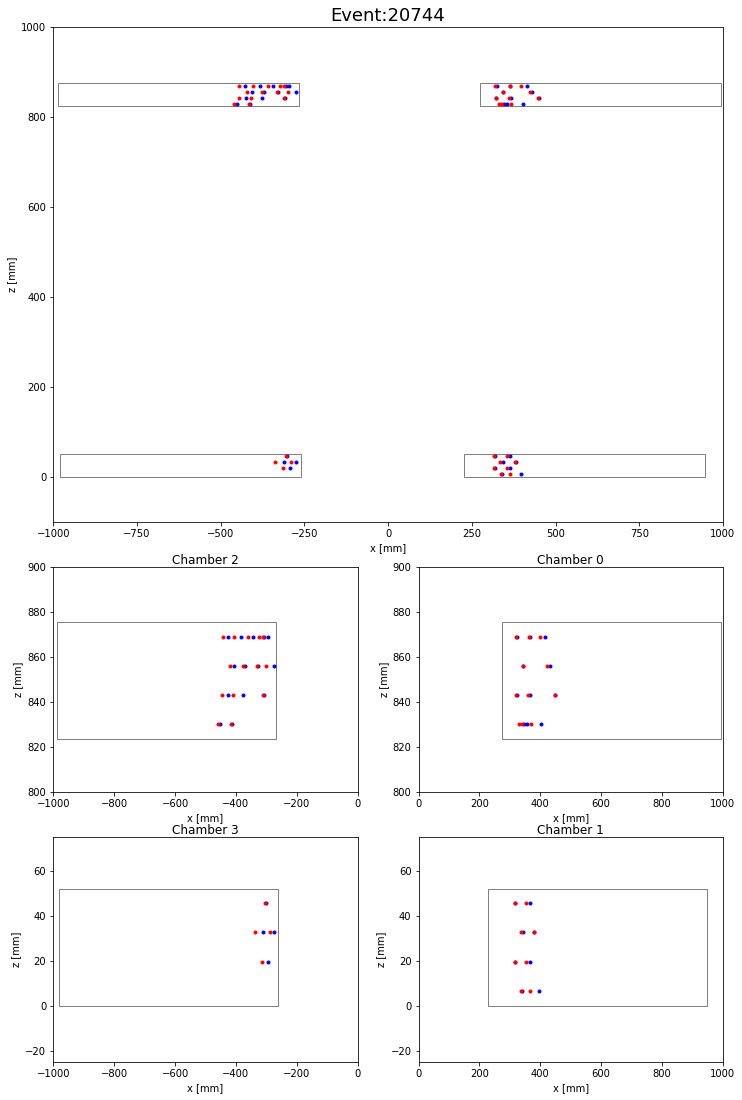

Trovato l'evento numero:  50
Trovato l'evento numero:  51
16000 / 422 000
Trovato l'evento numero:  52
Trovato l'evento numero:  53
17000 / 422 000
Trovato l'evento numero:  54
Trovato l'evento numero:  55
Trovato l'evento numero:  56
Trovato l'evento numero:  57
Trovato l'evento numero:  58
Trovato l'evento numero:  59
18000 / 422 000
Trovato l'evento numero:  60
Trovato l'evento numero:  61
19000 / 422 000
Trovato l'evento numero:  62
Trovato l'evento numero:  63
Trovato l'evento numero:  64
20000 / 422 000
Trovato l'evento numero:  65
21000 / 422 000
Trovato l'evento numero:  66
Trovato l'evento numero:  67
Trovato l'evento numero:  68
Trovato l'evento numero:  69
Trovato l'evento numero:  70
Trovato l'evento numero:  71
Trovato l'evento numero:  72
Trovato l'evento numero:  73
Trovato l'evento numero:  74
22000 / 422 000
Trovato l'evento numero:  75
Trovato l'evento numero:  76
Trovato l'evento numero:  77
23000 / 422 000
Trovato l'evento numero:  78
Trovato l'evento numero:  79
24

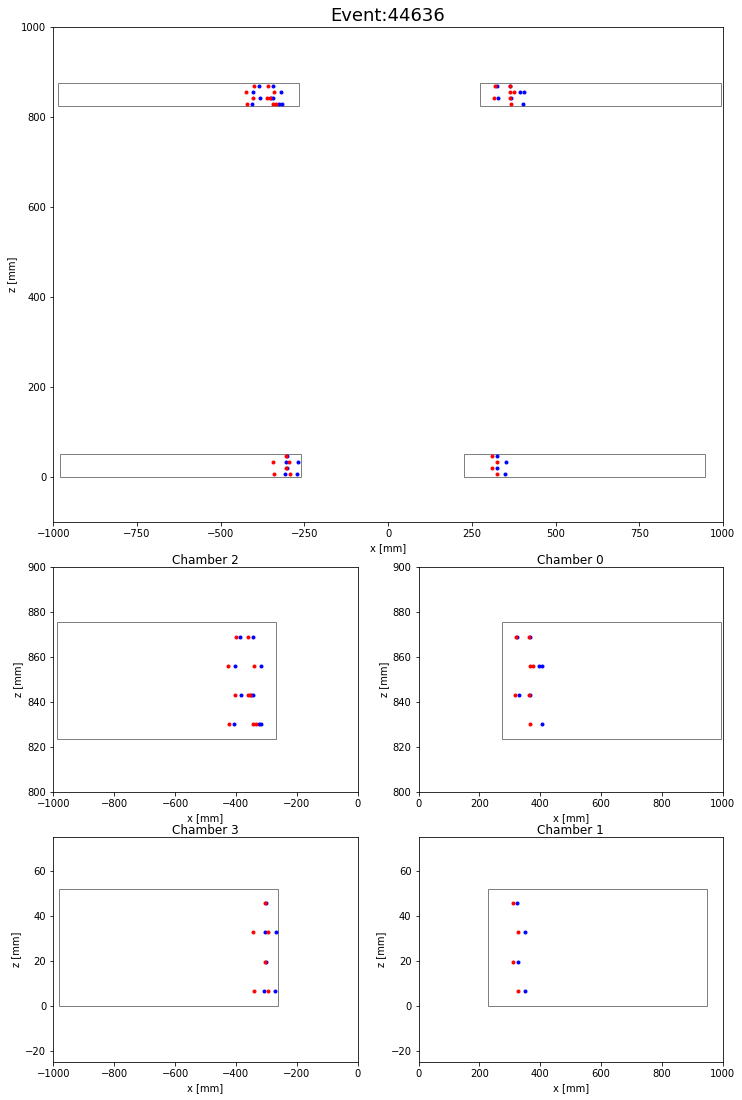

Trovato l'evento numero:  100
Trovato l'evento numero:  101
Trovato l'evento numero:  102
Trovato l'evento numero:  103
31000 / 422 000
Trovato l'evento numero:  104
Trovato l'evento numero:  105
32000 / 422 000
Trovato l'evento numero:  106
Trovato l'evento numero:  107
Trovato l'evento numero:  108
Trovato l'evento numero:  109
Trovato l'evento numero:  110
33000 / 422 000
Trovato l'evento numero:  111
Trovato l'evento numero:  112
Trovato l'evento numero:  113
Trovato l'evento numero:  114
34000 / 422 000
Trovato l'evento numero:  115
Trovato l'evento numero:  116
frazione elementi selezionati:  0.33983966538863714


In [26]:
data_file ="/Users/federicob/Documents/Physics_of_data/final_p/data/physics/merged/Run331.txt"
count=0
tot=0
eventi_selezionati=0
eventi_totali=0
Hit_dist=[]
with open(data_file) as f:
    for line in f:
        event = line.split()
        event = [float(i) for i in event]
        eventi_totali += 1
        
        
        
        #Open and read the event
        ev, evNumber, hits = read_data(event)
        Hit_dist.append(hits)
        
        
        dataframe_s,dataframe_d,number_hits_s,number_hits_d = filtro_punti(ev)
        dataframe_final=pd.concat([dataframe_s,dataframe_d])

        select_s, chambers_s, n_layers_s= select_events(dataframe_s,number_hits_s)
        select_d, chambers_d, n_layers_d= select_events(dataframe_d,number_hits_d)
        
        if (eventi_totali % 1000  ==0):
            print(eventi_totali,"/ 422 000") #deve trovare automaticamente il numero di eventi totali

        #print(number_hits)
        #print(select_s,select_d)
        if (select_s == True  and select_d==True):
            print("Trovato l'evento numero: ", eventi_selezionati)
            eventi_selezionati +=1
            if (eventi_selezionati%50 == 0):
                
                #Plot selected event    
                gridsize = (5, 2)
                fig = plt.figure(figsize = (12, 24))
                axes = plot_background()
                axes = plot_events(dataframe_final, evNumber)
                plt.show()
                #display(dataframe_s)
                #display(dataframe_d)

                
                
print("frazione elementi selezionati: ", eventi_selezionati/eventi_totali *100)

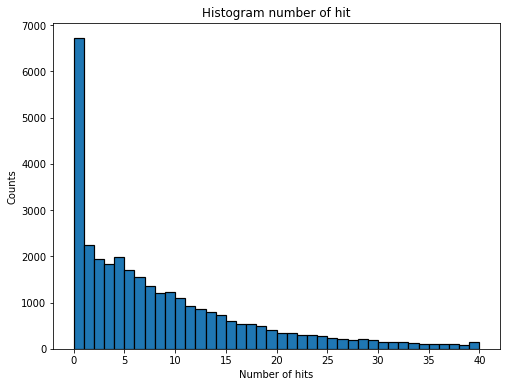

In [29]:
plt.figure(figsize=(8, 6))
plt.title("Histogram number of hit")
plt.xlabel("Number of hits")
plt.ylabel("Counts")
plt.hist(Hit_dist,range=(0,40),bins=40,edgecolor='black', linewidth=1.2)
plt.show()